The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
# Fill missing values in 'average_rating' and 'votes' columns with 0
df_reviews['average_rating'].fillna(0, inplace=True)
df_reviews['votes'].fillna(0, inplace=True)

In [7]:
# Drop rows with missing values
df_reviews.dropna(inplace=True)

In [8]:
# Reset the index
df_reviews.reset_index(drop=True, inplace=True)

In [9]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47331 non-null  float64
 10  votes            47331 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

## EDA

Let's check the number of movies and reviews over years.

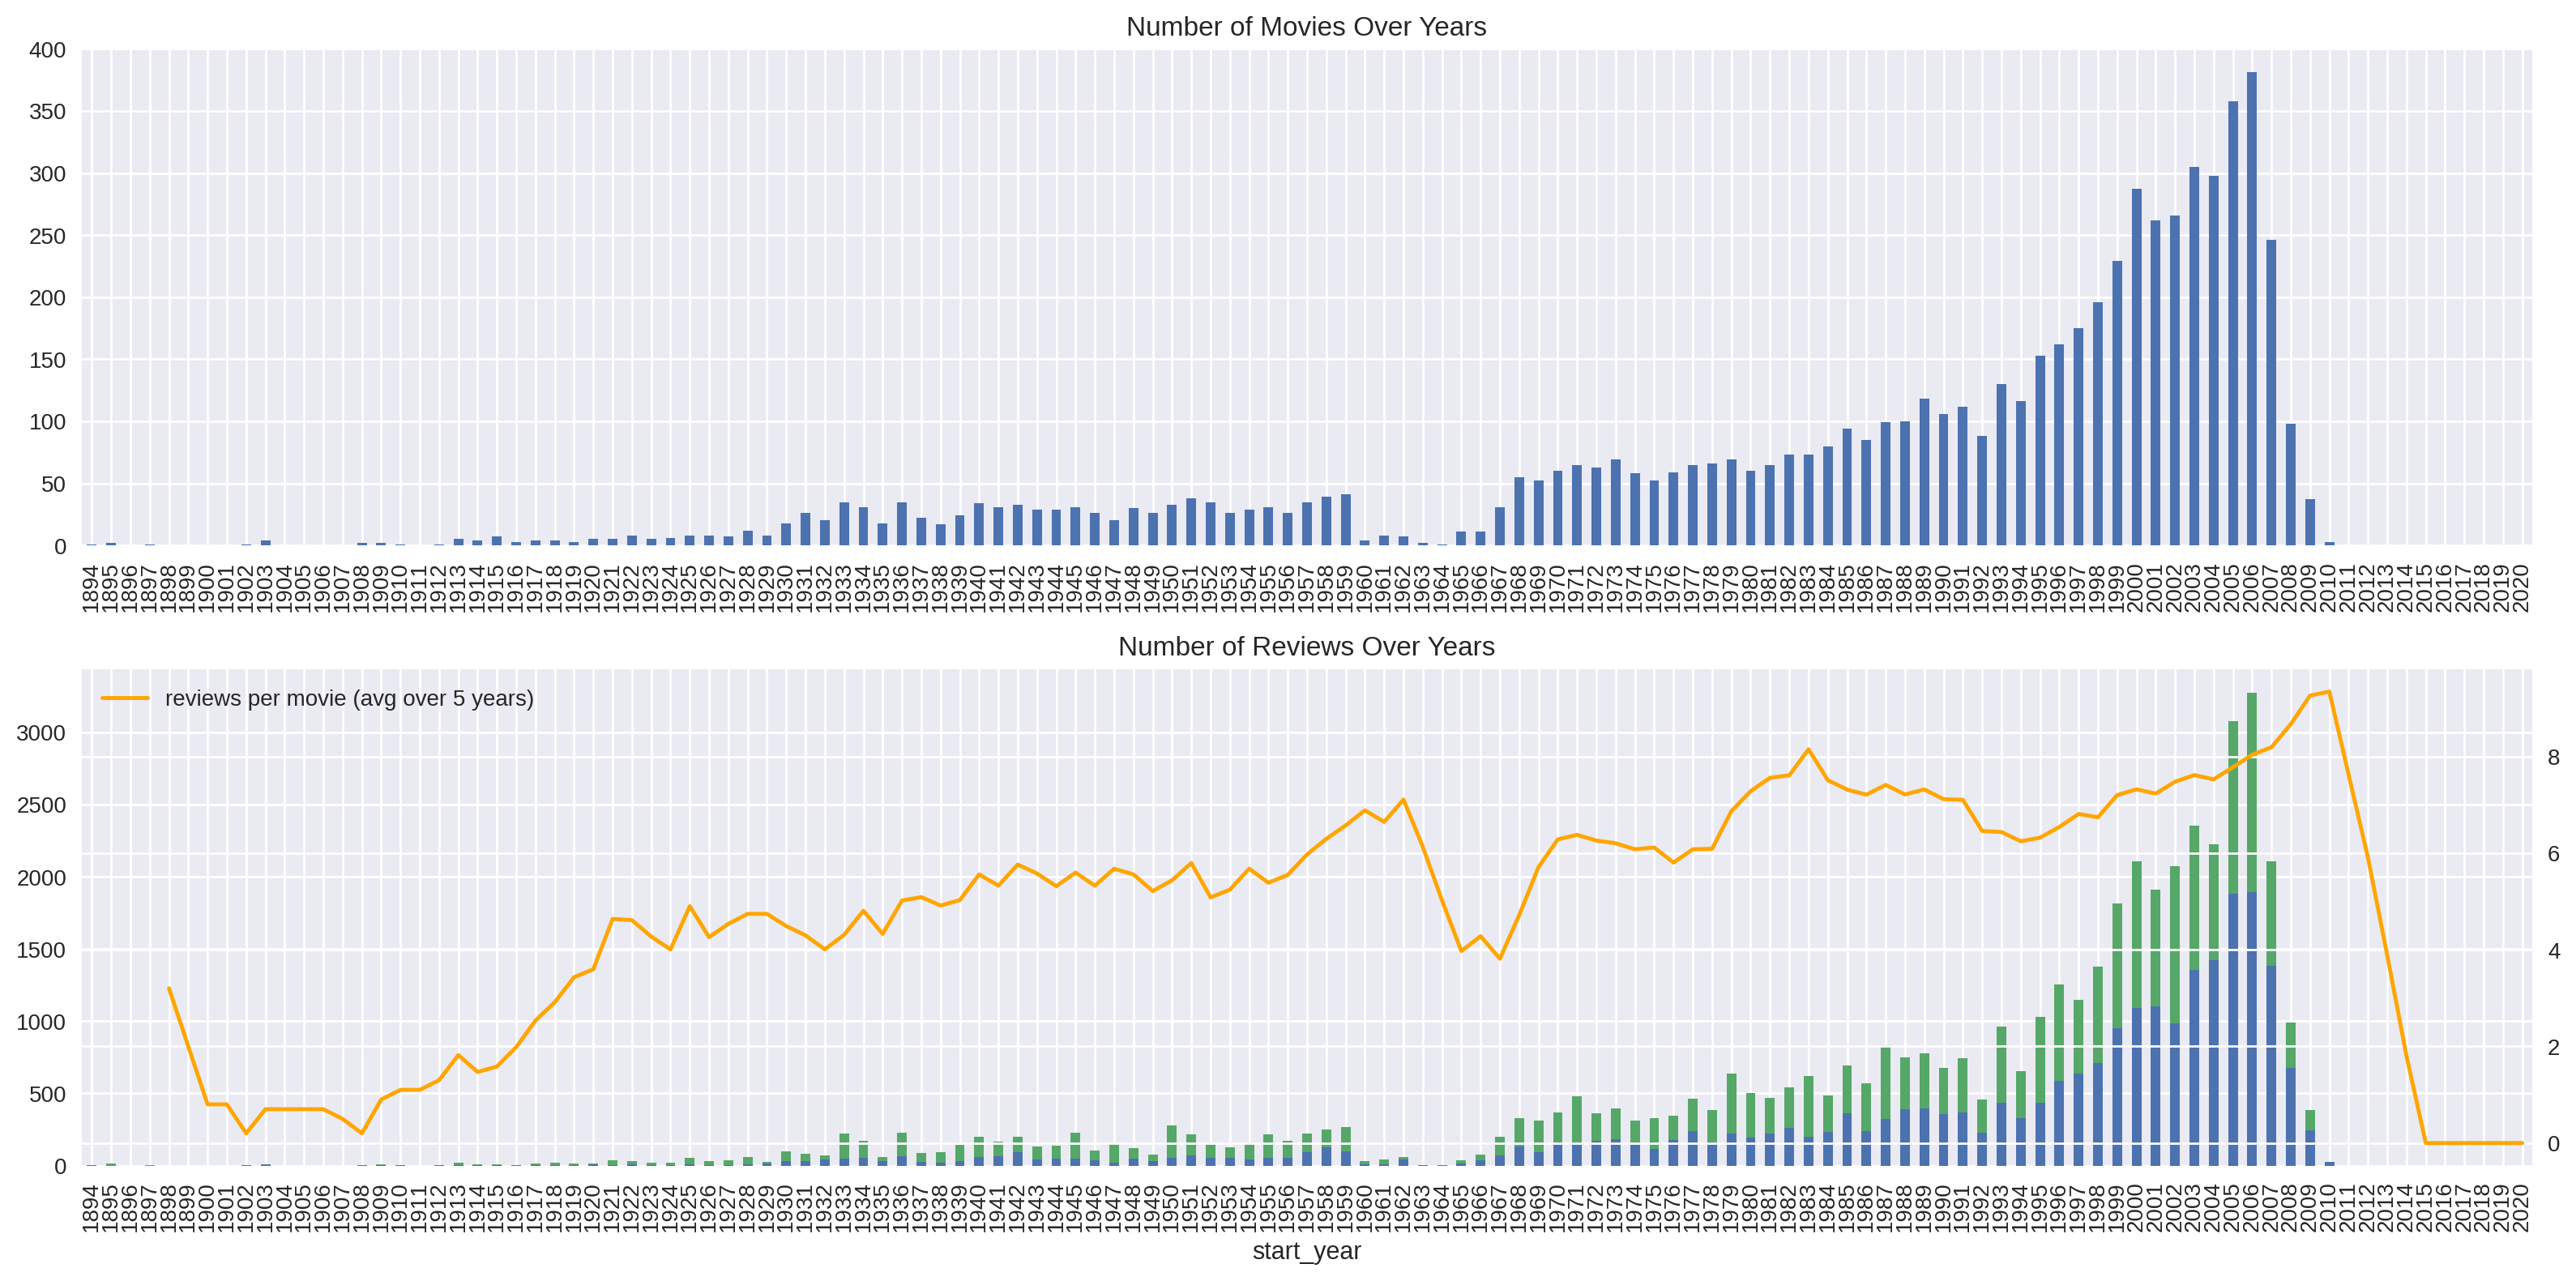

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

The data from the two graphs suggest a clear increase in the number of movies produced and reviews generated in recent years. The correlation between the number of movies and reviews further highlights the impact of the growing film industry on the public's engagement and feedback. While the trends show peaks around the early 2000s for both quantities, the average number of reviews per movie continues to rise into the 2010s before seeing a slight decline. This indicates a dynamic relationship between the quantity and quality of films being produced and reviewed in the modern era.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

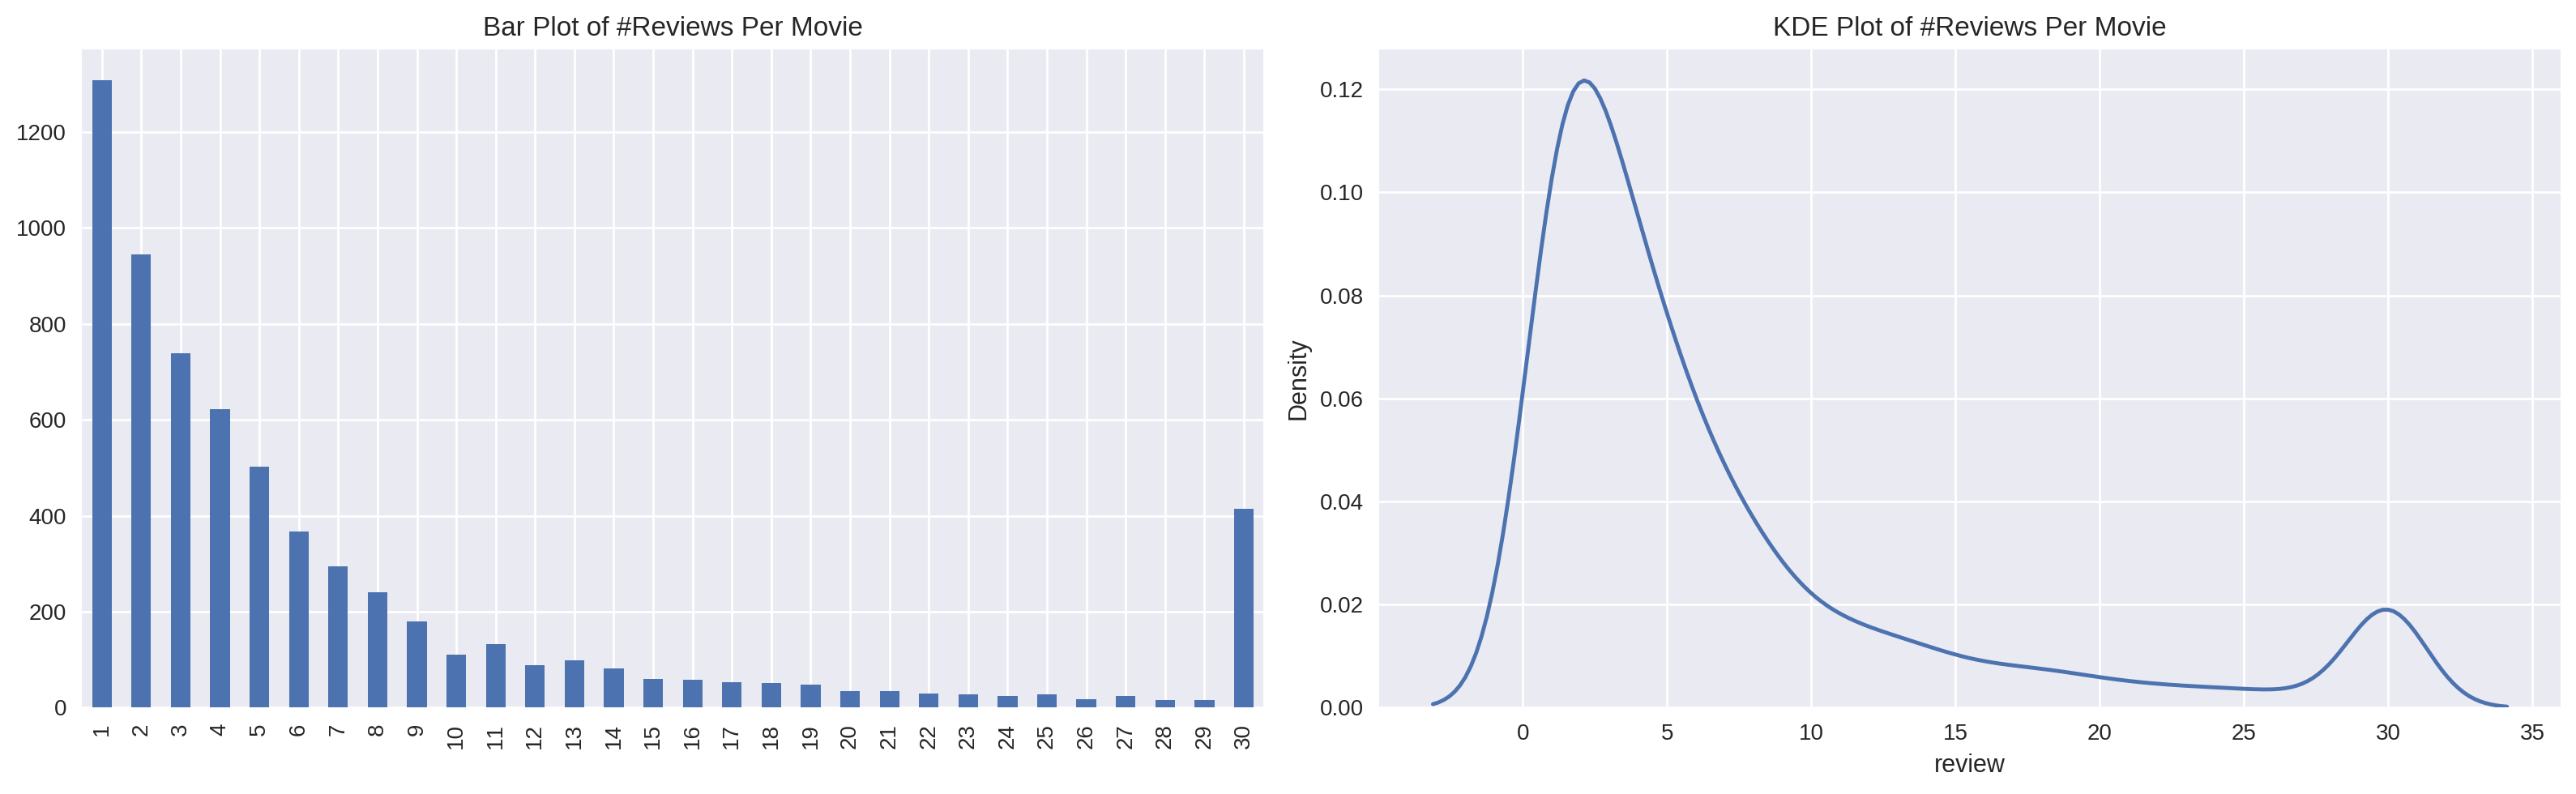

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

The analysis of the graphs of #reviews per movie indicates that the majority of movies receive only a small number of reviews, with a sharp decline in frequency as the number of reviews increases. The presence of a secondary peak suggests a smaller group of movies that receive a higher number of reviews, likely representing popular or significant films. This information provides valuable insights into the distribution of reviews in the dataset and highlights the disparity in attention received by movies within the dataset.

In [12]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

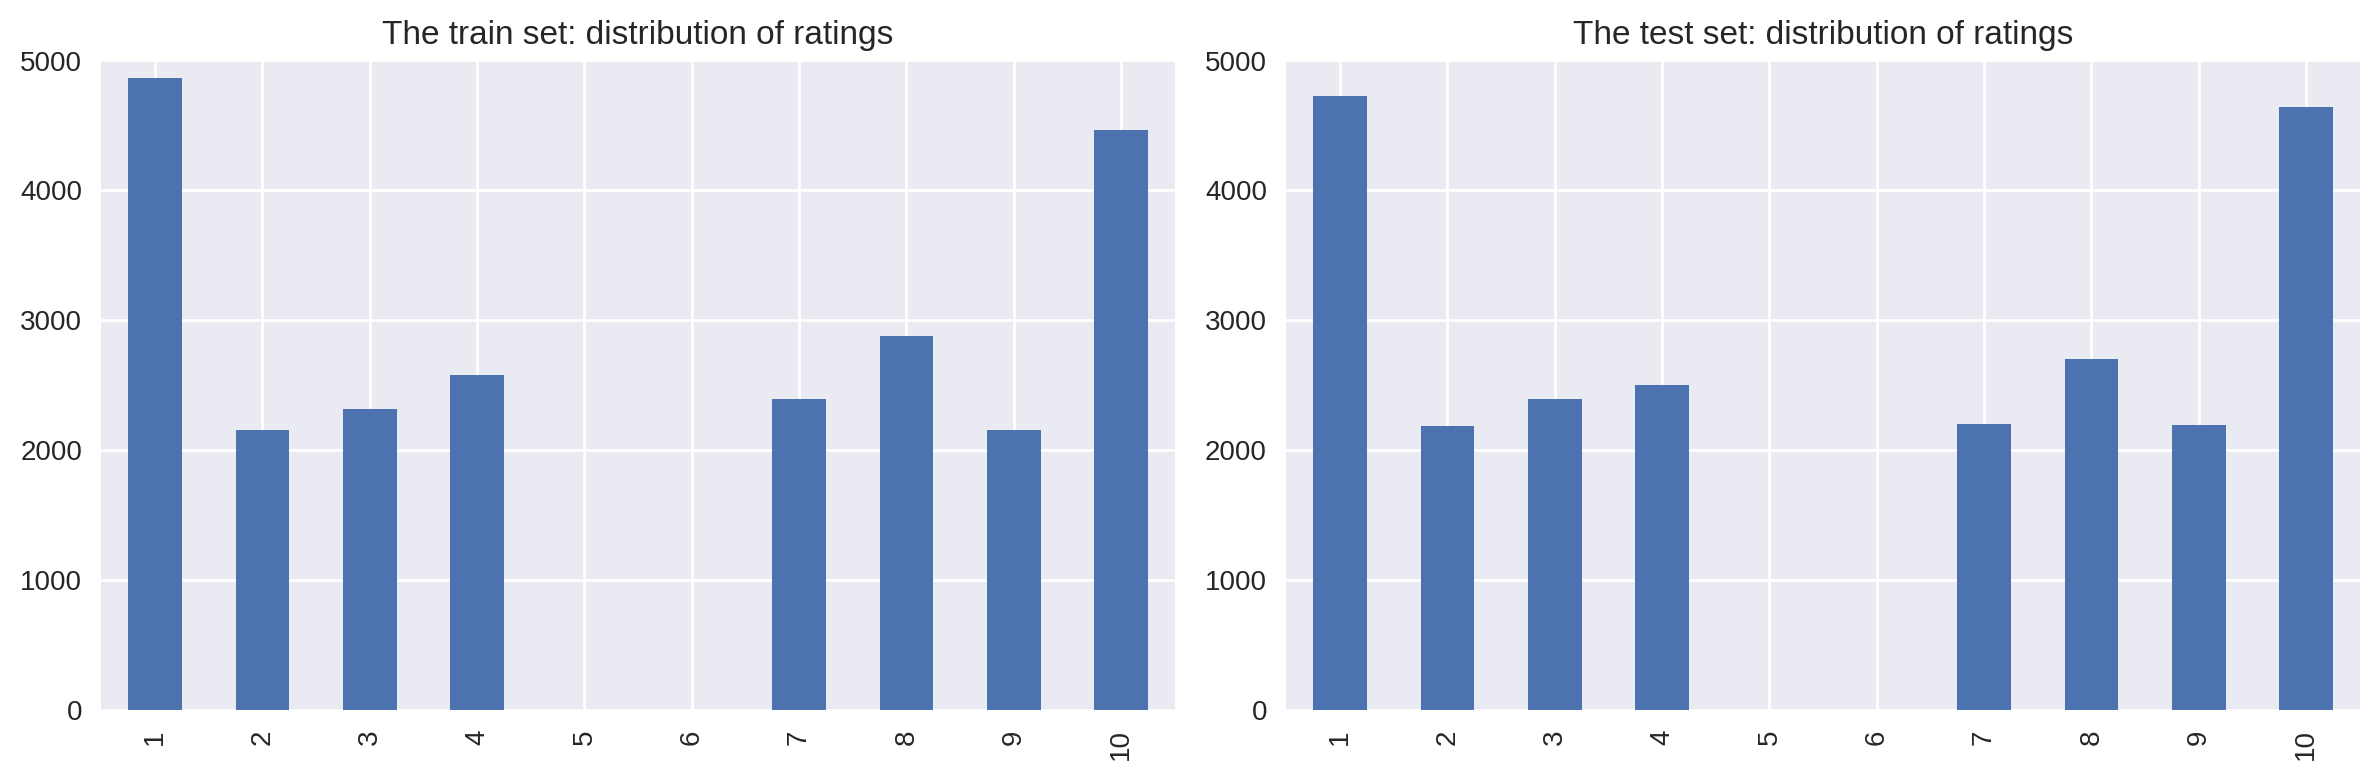

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

The analysis of the train set and test set distributions of ratings indicates a bimodal trend with peaks at ratings 1 and 10, as well as higher frequencies for ratings 4, 7, and 8. Both sets show consistency in their distributions, with extreme ratings being more common, suggesting polarizing opinions on movies. Overall, the patterns in both sets mirror each other, suggesting a reliable representation of the data.

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


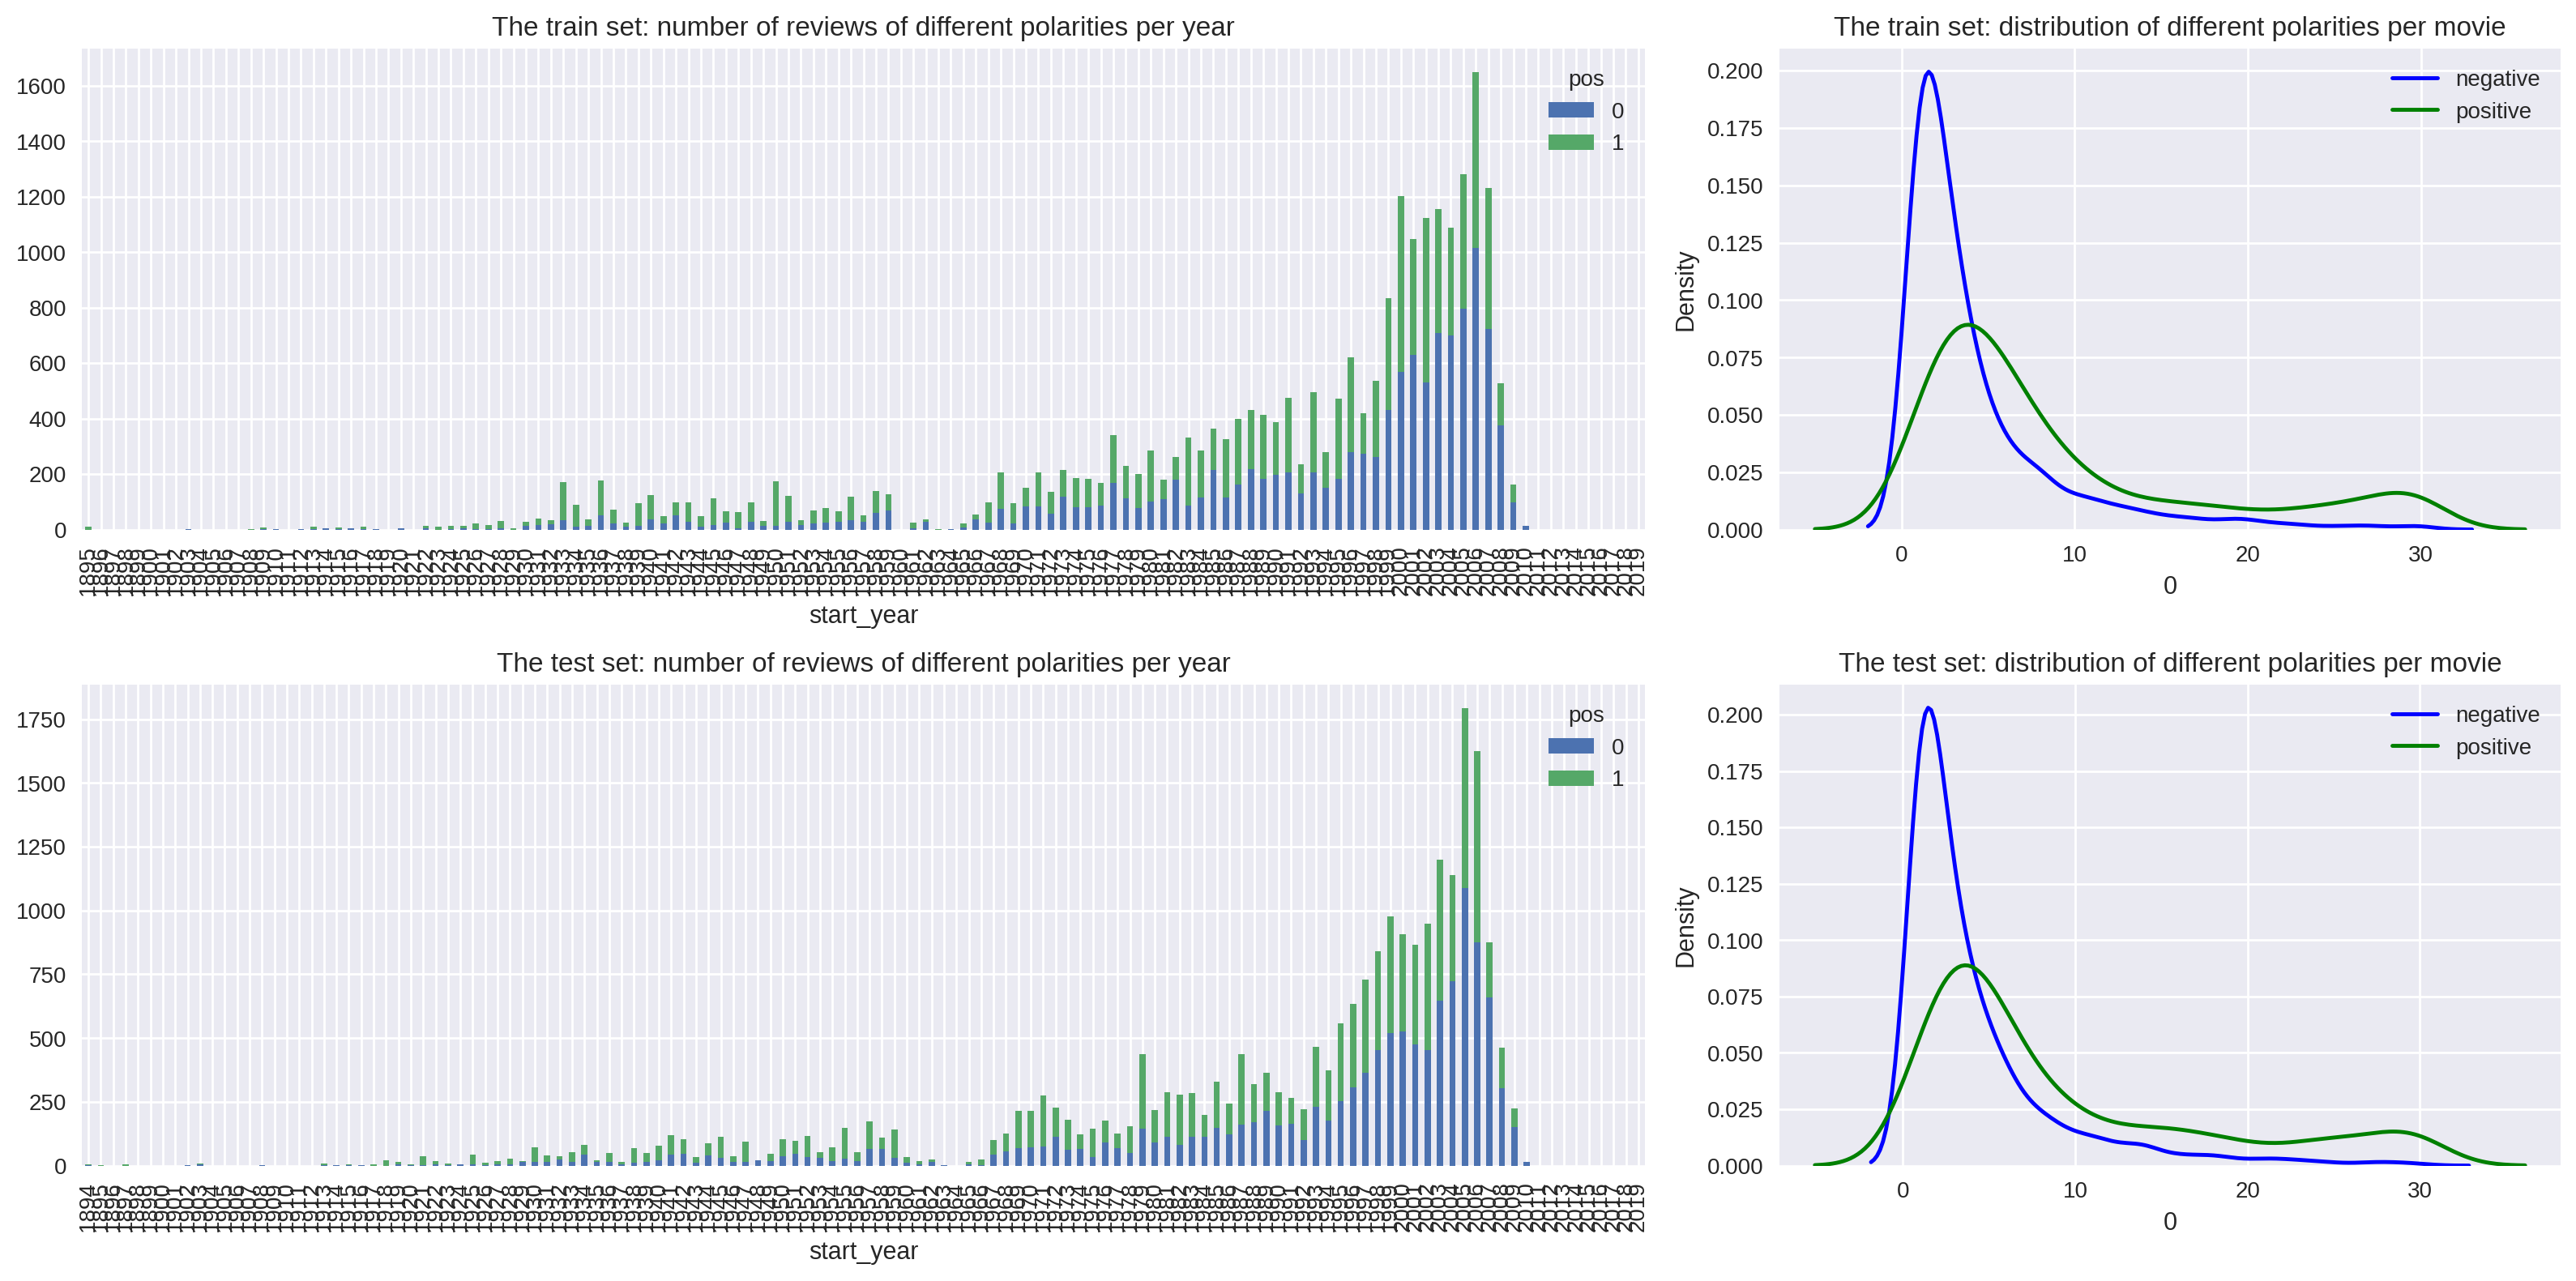

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

The analysis of the graphs shows that there has been a consistent increase in the number of both positive and negative reviews over time, with positive reviews slightly outnumbering negative ones. The distribution of reviews per movie also follows a similar pattern in both the train and test sets, with negative reviews slightly more concentrated at the lower end of the scale. Positive reviews are more frequent overall, but both polarities exhibit a similar distribution pattern.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [15]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [16]:
import re

df_reviews['review_norm'] = df_reviews['review'].apply(lambda x:re.sub(r'[^a-zA-Z\s]', '', x.lower()))

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [17]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [18]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


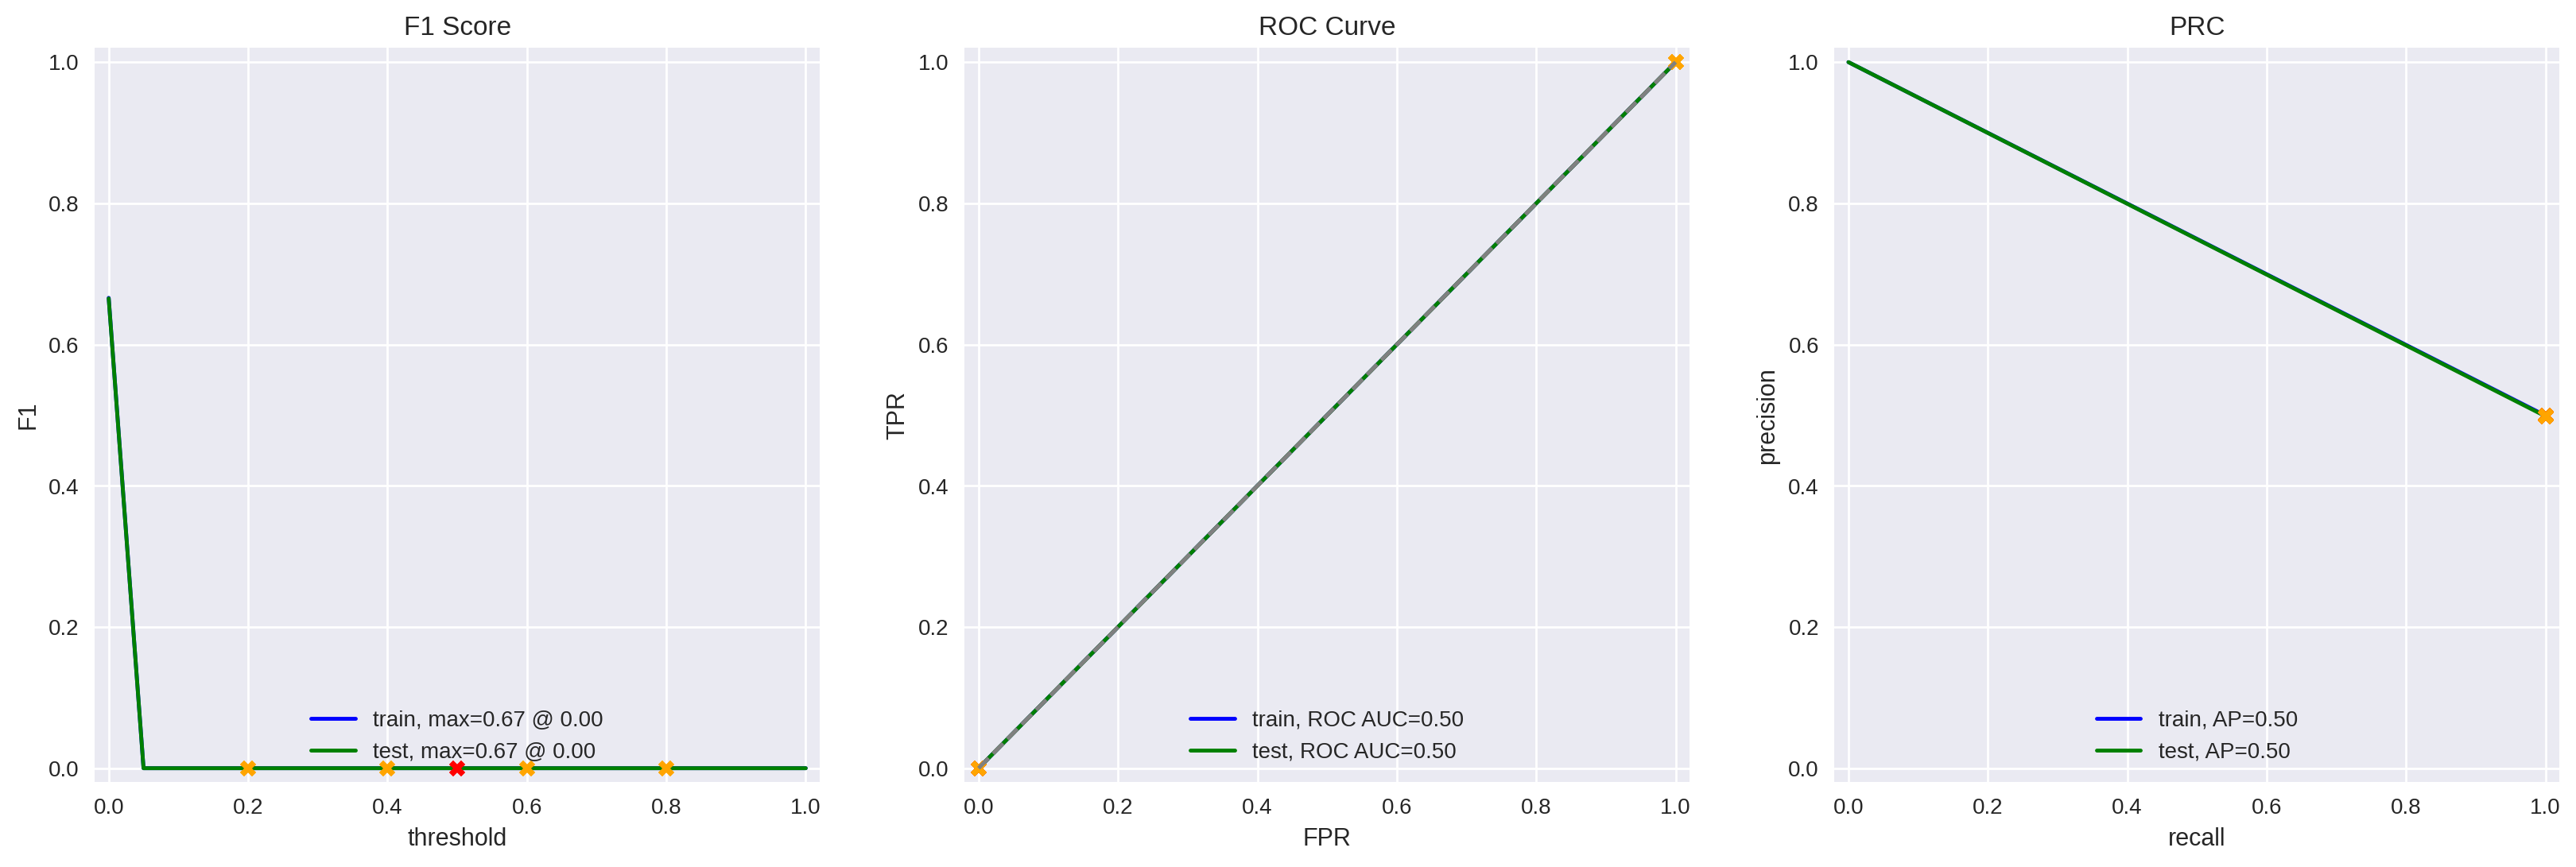

In [19]:
model0 = DummyClassifier(strategy='most_frequent')
model0.fit(df_reviews_train[['pos']], train_target)
evaluate_model(model0, df_reviews_train[['pos']], train_target, df_reviews_test[['pos']], test_target)

The model being evaluated is a Dummy Classifier with a strategy of 'most_frequent'. This means it will classify all instances as the most frequent class in the training data. The evaluation of the model on both the training and test data shows that it has an accuracy, F1 score, APS, and ROC AUC of 0.5 on both datasets, indicating that the model is not effective at predicting the target variable and is essentially making random guesses.

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [20]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [21]:
# Tokenizing and removing stopwords using NLTK
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

          train  test
Accuracy   0.95  0.89
F1         0.95  0.89
APS        0.99  0.95
ROC AUC    0.99  0.96


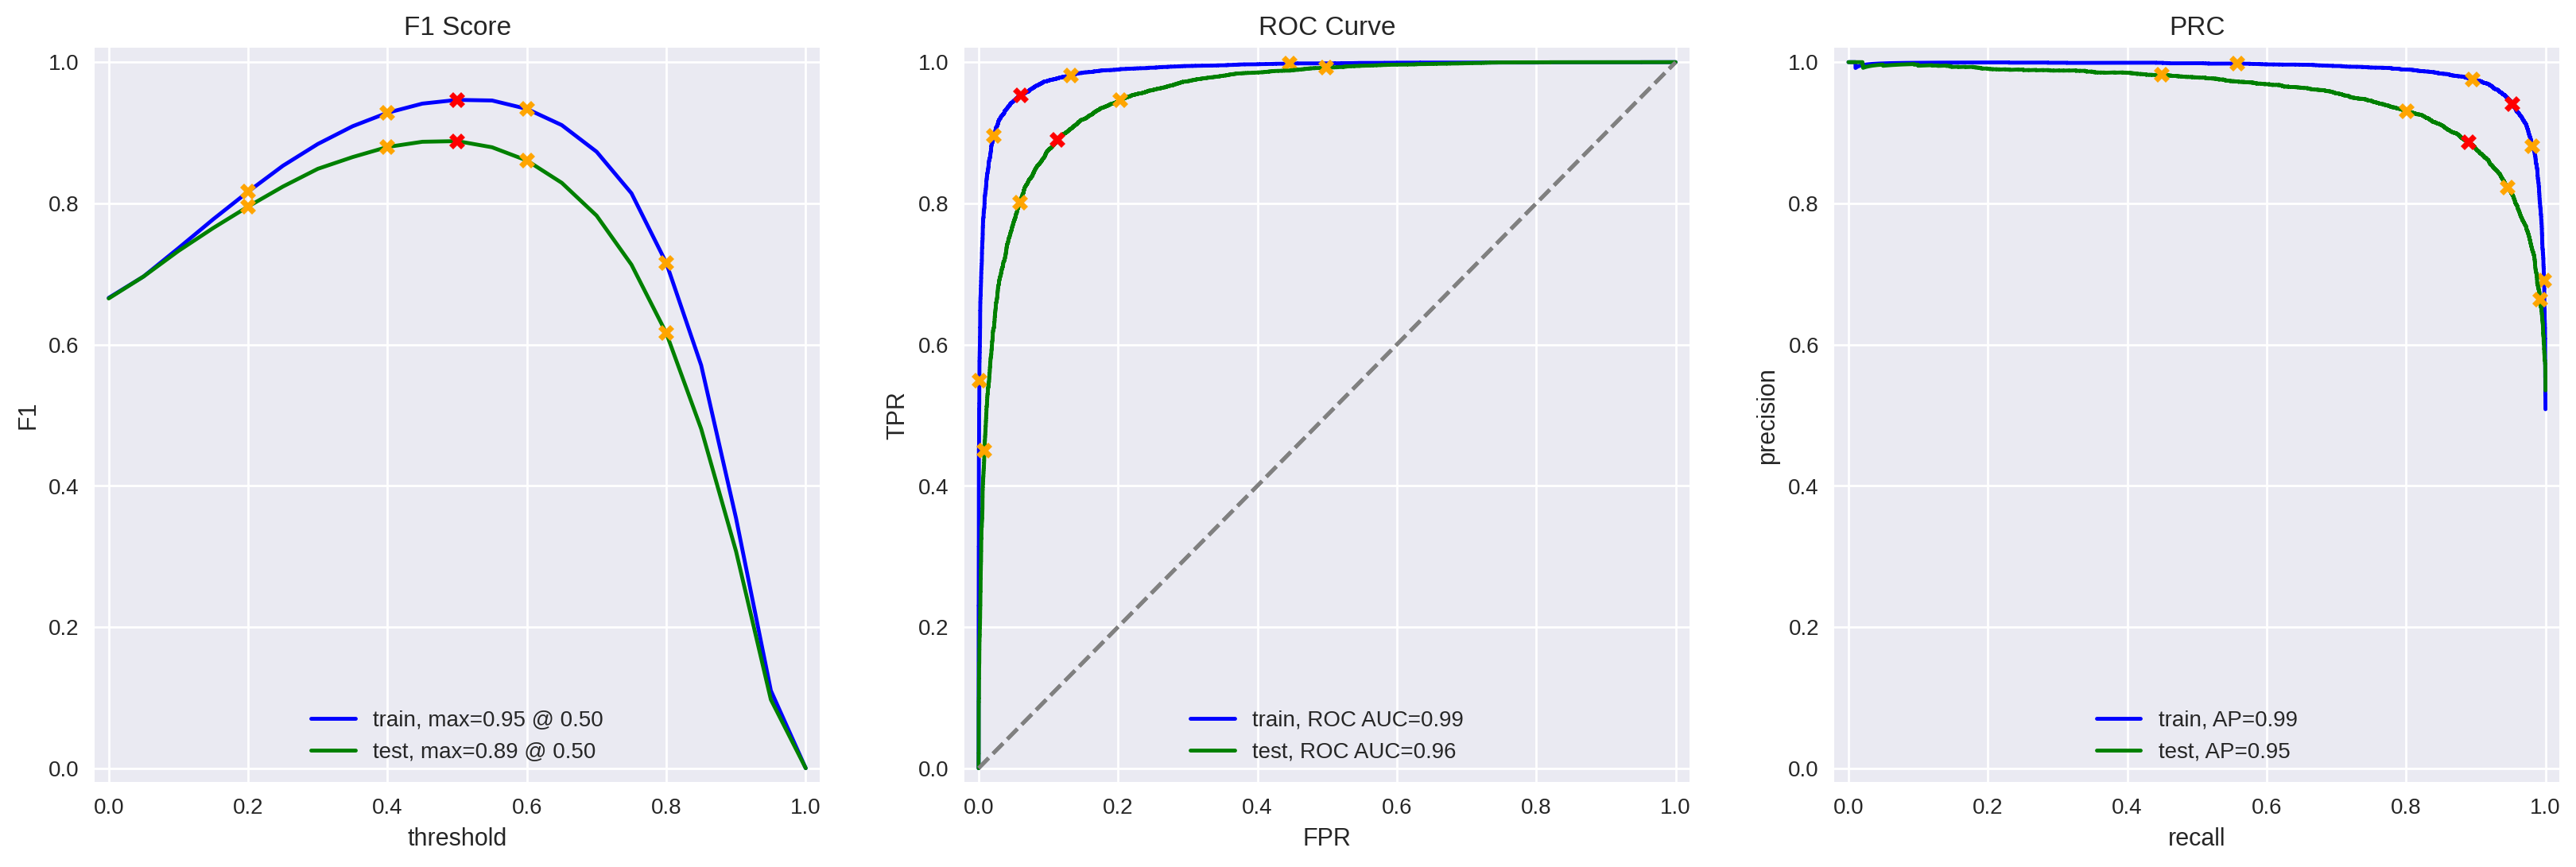

In [22]:
stop_words = set(stopwords.words('english'))

model1 = TfidfVectorizer(stop_words=stop_words, min_df=5, max_df=0.9, ngram_range=(1, 2))


train_features_1 = model1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = model1.transform(df_reviews_test['review_norm'])

model_1 = LogisticRegression()
model_1.fit(train_features_1, train_target)


evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

the process for building and evaluating a text classification model using TF-IDF vectorization and logistic regression. The model is trained on review data and then evaluated based on metrics such as accuracy, F1 score, average precision score (APS), and receiver operating characteristic area under the curve (ROC AUC). The model achieves high accuracy and performance on both the training and test data sets.

### Model 3 - spaCy, TF-IDF and LR

In [23]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.99  0.95
ROC AUC    0.99  0.95


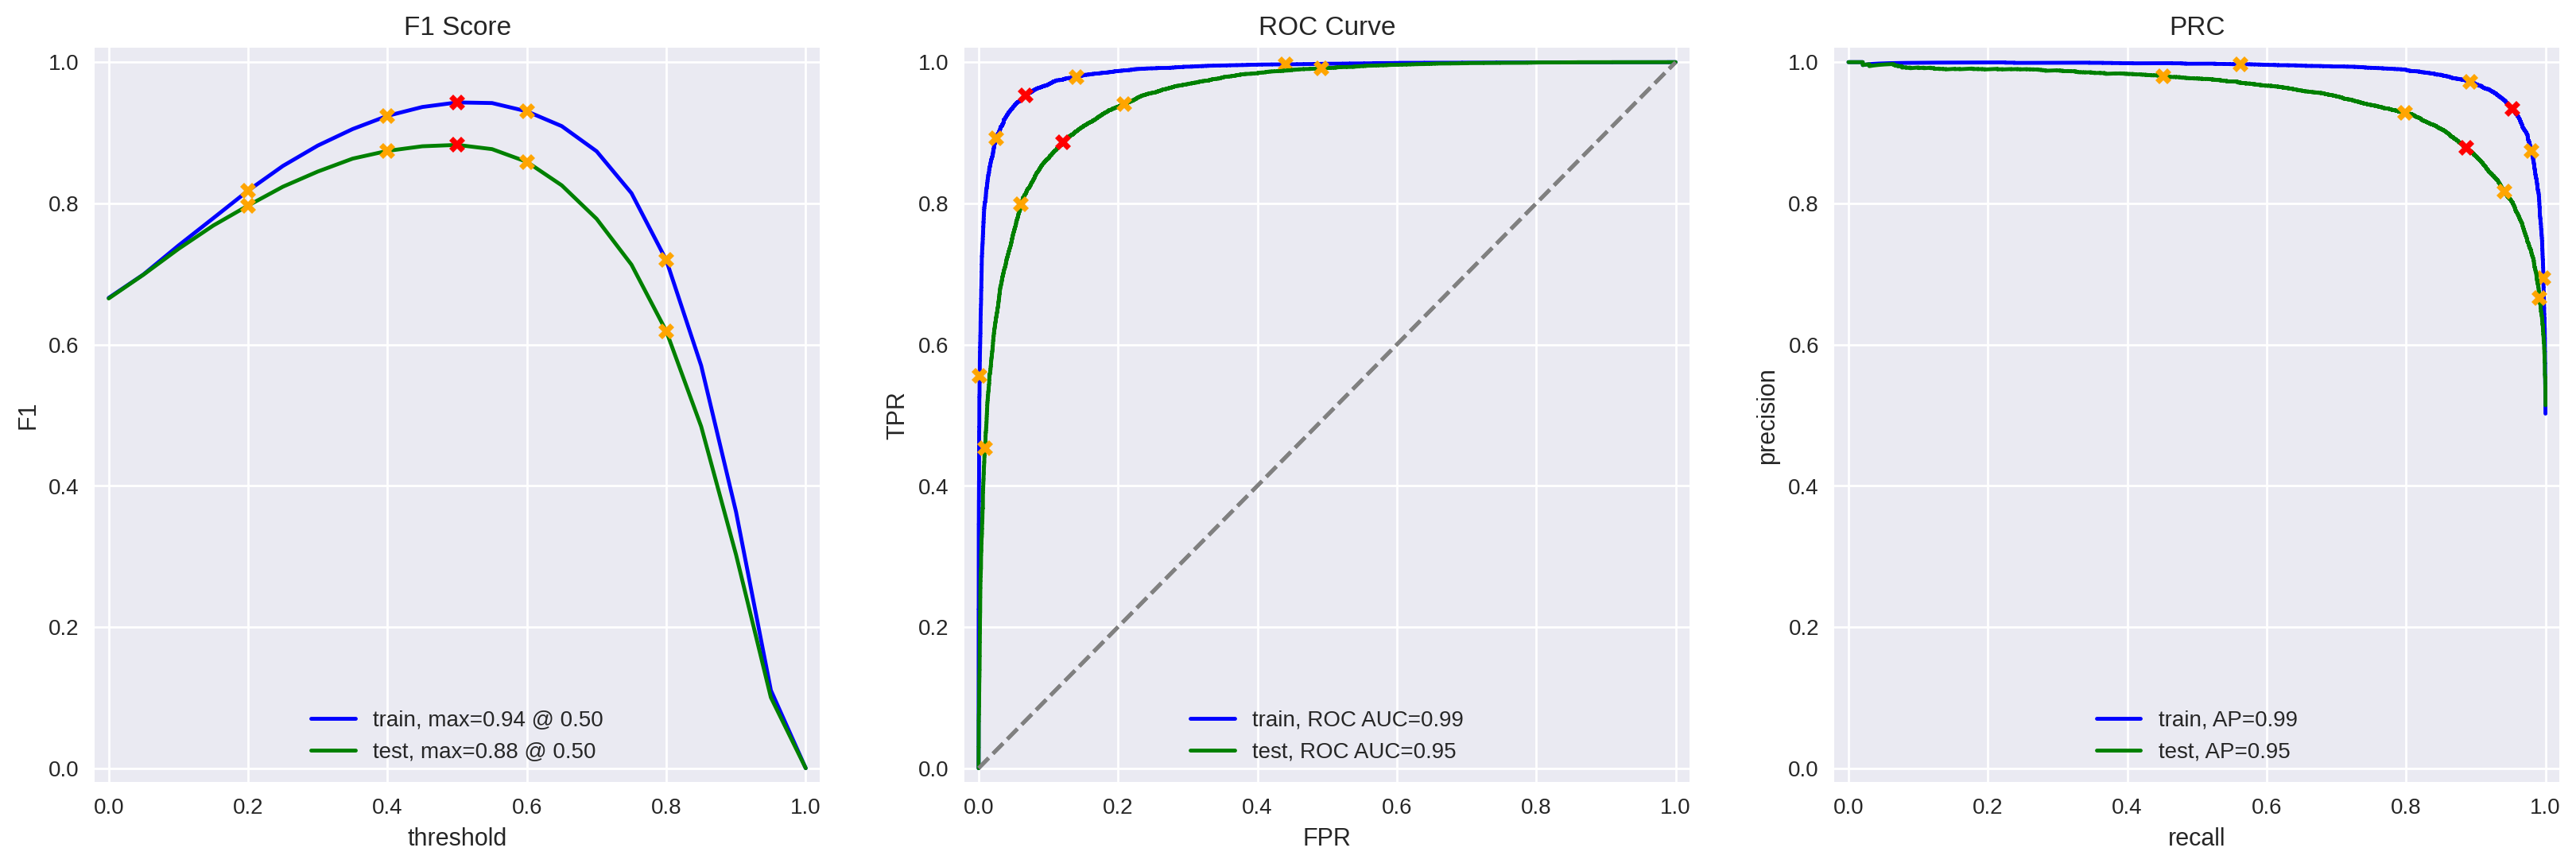

In [26]:
# Load the Spacy English model
nlp = spacy.load('en_core_web_sm')

# Define the text preprocessing function
def text_preprocessing_3(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)

# Initialize TF-IDF Vectorizer with stop_words argument in a Pipeline
model3 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, min_df=5, max_df=0.9, ngram_range=(1, 2))),
    ('clf_lr', LogisticRegression())
])


# Lemmatize the texts
df_reviews_train['review_norm'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_norm'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

# Fit the entire pipeline on the training data
model3.fit(df_reviews_train['review_norm'], train_target) 

# Evaluate the model using the test set
evaluate_model(model3,df_reviews_train['review_norm'], train_target,df_reviews_test['review_norm'], test_target)

The Logistic Regression spaCy, TF-IDF after implementing text preprocessing that included lemmatization using the Spacy English model and initializing a TF-IDF Vectorizer in a Pipeline with stop words, the model achieved high accuracy, F1 score, APS, and ROC AUC on both the training and test data. This demonstrates the effectiveness of the text preprocessing techniques in improving the model's performance in sentiment analysis. 
The model achieved the following evaluation metrics on the training and test sets: 
- Accuracy: 0.94 (training), 0.88 (test)
- F1 score: 0.94 (training), 0.88 (test)
- Average Precision Score (APS): 0.99 (training), 0.95 (test)
- ROC AUC: 0.99 (training), 0.95 (test)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [27]:
from lightgbm import LGBMClassifier

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.94
ROC AUC    0.97  0.94


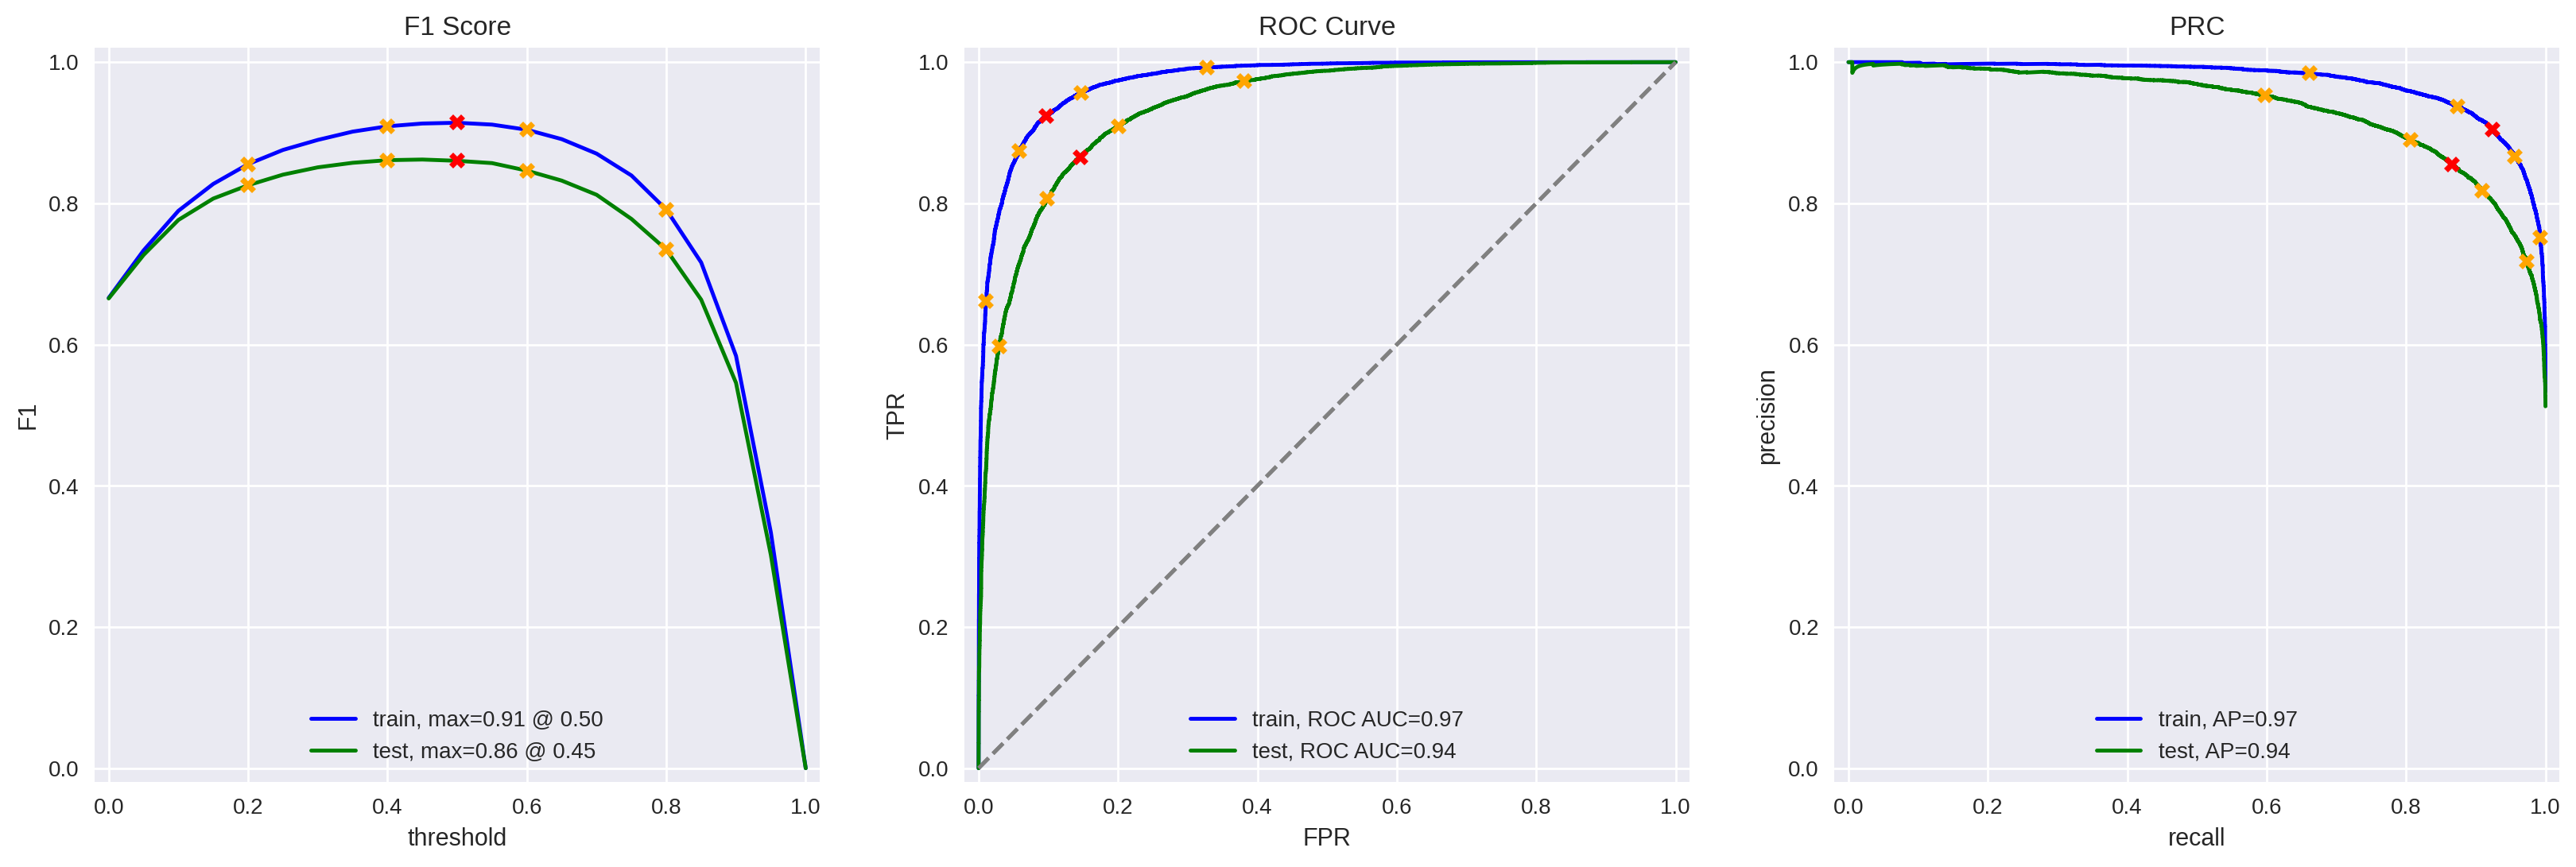

In [29]:
# Initialize TF-IDF Vectorizer with stop_words argument in a Pipeline
model4 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, min_df=5, max_df=0.9, ngram_range=(1, 2))),
    ('clf_lr', LGBMClassifier())
])

model4.fit(df_reviews_train['review_norm'], train_target)

# Evaluate the model using the test set
evaluate_model(model4,df_reviews_train['review_norm'], train_target,df_reviews_test['review_norm'], test_target)

The LightGBM model is evaluated using the test set to calculate metrics such as accuracy, F1 score, Average Precision Score (APS), and ROC AUC score. The results of the evaluation show that the model has an accuracy of 0.91 on the training set and 0.86 on the test set, with similar scores for F1, APS, and ROC AUC.

## My Reviews

In [30]:
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x:re.sub(r'[^a-zA-Z\s]', '', x.lower()))

display(my_reviews)

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


In [37]:
# Model 1
texts_tfidf = model1.transform(my_reviews['review_norm'])

my_reviews_pred_prob_model_1 = model_1.predict_proba(texts_tfidf)[:, 1]

print("Model 1:")
for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_model_1[i]:.2f}:  {review}')

Model 1:
0.27:  I do not simply like it not my kind of movie
0.37:  well I be bored and feel asleep in the middle of the movie
0.55:  I be really fascinated with the movie
0.28:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.36:  I do not expect the reboot to be so good writer really care about the source material
0.52:  the movie have its upside and downside but I feel like overall its a decent flick I could see myself
0.08:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.84:  launch on netflix be a brave move      I really appreciate be able to binge on episode after episode


In [35]:
# Model 3 
my_reviews['review_norm'] = my_reviews['review_norm'].apply(text_preprocessing_3)

my_reviews_pred_prob_model3 = model3.predict_proba(my_reviews['review_norm'])[:, 1]

for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_model3[i]:.2f}:  {review}')

0.26:  I do not simply like it not my kind of movie
0.22:  well I be bored and feel asleep in the middle of the movie
0.49:  I be really fascinated with the movie
0.16:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.29:  I do not expect the reboot to be so good writer really care about the source material
0.39:  the movie have its upside and downside but I feel like overall its a decent flick I could see myself
0.08:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.90:  launch on netflix be a brave move     I really appreciate be able to binge on episode after episode 


In [36]:
# Model 4
my_reviews['review_norm'] = my_reviews['review_norm'].apply(text_preprocessing_3)

my_reviews_pred_prob_model4 = model4.predict_proba(my_reviews['review_norm'])[:, 1]

for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_model4[i]:.2f}:  {review}')

0.60:  I do not simply like it not my kind of movie
0.46:  well I be bored and feel asleep in the middle of the movie
0.64:  I be really fascinated with the movie
0.37:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.63:  I do not expect the reboot to be so good writer really care about the source material
0.70:  the movie have its upside and downside but I feel like overall its a decent flick I could see myself
0.32:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.81:  launch on netflix be a brave move      I really appreciate be able to binge on episode after episode


## Conclusions

In conclusion, the project undertaken by the Film Junky Union to develop a system for filtering and categorizing movie reviews has been successful in achieving the goal of automatically detecting negative reviews. The initial model using a Dummy Classifier with a strategy of 'most_frequent' proved to be ineffective, as expected, but subsequent models using Logistic Regression with TF-IDF vectorization and text preprocessing techniques, as well as LightGBM, yielded impressive results in terms of accuracy, F1 score, APS, and ROC AUC. The final models achieved high levels of accuracy and performance on both the training and test datasets, with F1 scores exceeding the target of 0.85. This demonstrates the effectiveness of the text preprocessing techniques and modeling approaches in improving the model's performance in sentiment analysis. Overall, the project has successfully created a robust model for classifying positive and negative movie reviews, providing valuable insights for classic movie enthusiasts within the Film Junky Union community.